In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.core.frame import DataFrame
from scipy import stats

In [4]:
data = pd.read_csv('data\\data.csv', sep=';')
data.head()

,Z1-4,Z5A,Z5B,Z6I,Z6IIA,Z6IIB,Z7A,Z7B,Z8A,Z8B,Z9A,Z9B,Z10A,Z10B,Z11,Z12,Z13,"Z14,15,16_x","Z14,15,16_y",Unnamed: 19
0,122.3,152.0,158.8,B,133.7,131.6,168.3,172.2,54.9,76.3,85.8,154.7,24.7,27.7,103.3,100.7,118.5,120.6,84.4,NaN
1,117.9,161.4,159.2,B,170.7,157.0,173.2,154.7,50.9,60.9,134.8,137.2,18.4,20.4,93.9,91.5,122.4,124.2,76.9,NaN
2,118.0,140.1,151.5,B,169.2,155.3,186.1,167.4,28.2,66.2,174.0,146.7,29.5,30.4,96.3,96.5,120.4,126.2,82.3,NaN
3,124.0,147.0,160.4,B,163.1,148.2,160.7,176.6,54.2,89.9,177.9,142.9,30.2,25.8,92.2,94.3,117.9,127.6,80.0,NaN
4,126.5,150.6,152.2,B,144.1,143.4,177.9,160.7,42.7,68.9,163.4,136.3,20.7,26.0,97.4,104.7,120.3,128.9,76.7,NaN


# Исследование зависимости между двумя характеристиками

## Проверить независимость двух характеристик по критерию сопряжённости хи-квадрат

По выборке (X1, Y1),...,(Xn, Yn) из двумерного распределения (необязательно нормального) проверить гипотезу независимости компонент наблюдаемого случайного вектора (X, Y).

In [56]:
def chi2_independence_crit(x_data: np.array,
                           y_data: np.array,
                           x0: float, delta_x: float, r: int,
                           y0: float, delta_y: float, s: int,
                           alp: float=0.1):
    """
    Проверка независимости по критерию сопряженности Хи-квадрат
    Args:
        x_data: данные X
        y_data: данные Y
        x0: первая граница интервала для данных X
        delta_x: шаг между границами интервала для данных X
        r: количество интервалов для данных X
        y0: первая граница интервала для данных Y
        delta_y: шаг между границами интервала для данных Y
        s: количество интервалов для данных Y
        alp: уровень значимости
    """
    n = x_data.shape[0]
    if n != y_data.shape[0]:
        raise Exception('X and Y data are different size!')
    
    interval_x = np.array([x0 + i * delta_x for i in range(r - 1)])
    interval_y = np.array([y0 + i * delta_y for i in range(s - 1)])
    
    freq_xy = np.zeros((r, s))
    for i in range(r):
        for j in range(s):
            if i == 0:
                x_cond = x_data < interval_x[0]
            elif i == r - 1:
                x_cond = x_data >= interval_x[-1]
            else:
                x_cond = np.all((x_data >= interval_x[i-1],
                                 x_data < interval_x[i]), axis=0)
            if j == 0:
                y_cond = y_data < interval_y[0]
            elif j == s - 1:
                y_cond = y_data >= interval_y[-1]
            else:
                y_cond = np.all((y_data >= interval_y[j-1],
                                 y_data < interval_y[j]), axis=0)
            freq_xy[i][j] = sum(x_cond * y_cond)
    
    freq_xy = np.hstack((freq_xy, freq_xy.sum(axis=1).reshape(-1, 1))) # freq_i*
    freq_xy = np.vstack((freq_xy, freq_xy.sum(axis=0).reshape(1, -1))) # freq_*2

    T_stat = 0
    for i in range(r):
        for j in range(s):
            T_stat += ((n * freq_xy[i][j] - freq_xy[i][-1] * freq_xy[-1][j]) ** 2)\
                    / (n * freq_xy[i][-1] * freq_xy[-1][j])
    
    print("Хи^2 cтатистика:", T_stat)
    print("Уровень значимость:", alp)
    
    p_value = 1 - stats.chi2.pdf(T_stat, df=(r - 1) * (s - 1))
    T_crit = stats.chi2.ppf(alp, df=(r - 1) * (s - 1))
    print(f"Крит. область T < {T_crit}")
    
    print('p-value:', p_value)
    if p_value < alp:
        print(f"Гипотеза отклоняется, выборки зависимые!")
    else:
        print(f"Гипотеза не отклоняется, выборки незивисимые!")

In [57]:
X_data = data['Z14,15,16_x'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z14,15,16_y'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

chi2_independence_crit(X_data, Y_data,
                       x0=118.05, delta_x=2, r=5,
                       y0=79.05, delta_y=3, s=3)

Хи^2 cтатистика: 6.0916653062588315
Уровень значимость: 0.1
Крит. область T < 3.4895391256498227
p-value: 0.8880179136365075
Гипотеза не отклоняется, выборки незивисимые!


## Проверка независимости двух нормальных выборок по критерию Стьюдента

По выборке (X1, Y1),...,(Xn, Yn) из двумерного распределения нормального распределения проверить гипотезу независимости компонент наблюдаемого случайного вектора (X, Y).

In [76]:
def t_independence_crit(x_data: np.array,
                           y_data: np.array,
                           alp: float=0.1,
                           alternative: str='more'):
    """
    Проверка независимости по критерию Стьюдента
    Args:
        x_data: данные X
        y_data: данные Y
        alp: уровень значимости
        alternative (more, less, difference): r > 0 - more,
                                                r < 0 - less,
                                                r != 0 - difference
    """
    n = x_data.shape[0]
    if n != y_data.shape[0]:
        raise Exception('X and Y data are different size!')
        
    r = np.corrcoef(X_data, Y_data)[0][-1]
    T_stat = r * math.sqrt(n - 2) / math.sqrt(1 - r * r)
    
    if alternative == 'more':
        p_value = 1 - stats.t.cdf(T_stat, df=n - 2)
        c_crit = stats.t.ppf(alp, df=n - 2)
    elif alternative == 'less':
        p_value = stats.t.cdf(T_stat, df=n - 2)
        c_crit = stats.t.ppf(1 - alp, df=n - 2)
    elif alternative == 'difference':
        p_value = 2 * (1 - stats.t.cdf(abs(T_stat), df=n - 2))
        c_crit = stats.t.ppf(1 - alp / 2, df=n - 2)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    
    print("T cтатистика:", T_stat)
    print("Уровень значимость:", alp)
    
    if alternative == 'more':
        print("Крит. область T >", c_crit)
    elif alternative == 'less':
        print("Крит. область T <", c_crit)
    elif alternative == 'difference':
        print("Крит. область |T| >", c_crit)
    else:
        raise Exception('Alternative should be like more, less, difference!')
    
    print('p-value:', p_value)
    if p_value < alp:
        print(f"Гипотеза отклоняется, выборки зависимые!")
    else:
        print(f"Гипотеза не отклоняется, выборки незивисимые!")
    

In [77]:
X_data = data['Z14,15,16_x'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z14,15,16_y'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

t_independence_crit(X_data, Y_data, alternative='difference')

T cтатистика: 1.4921816268109829
Уровень значимость: 0.1
Крит. область |T| > 1.662155325834565
p-value: 0.13918788847303887
Гипотеза не отклоняется, выборки незивисимые!


## Линейная регрессия

In [93]:
def linear_reg(x_data: np.array,
               y_data: np.array):
    """
    Построение линейной регрессии
    Args:
        x_data: Данные X
        y_data: Данные Y
    """
    n = x_data.shape[0]
    if n != y_data.shape[0]:
        raise Exception('X and Y data are different size!')
        
    x_mean = x_data.mean()
    y_mean = y_data.mean()
    x_std = x_data.std()
    y_std = y_data.std()
    
    r = np.corrcoef(X_data, Y_data)[0][-1]
    
    a_xy = r * y_std / x_std
    b_xy = y_mean - x_mean * a_xy
    x_xy_line = np.linspace(x_data.min() - 10, x_data.max() + 10, 2)
    y_xy_line = a_xy * x_xy_line + b_xy
    
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    axs.set_title('Линейная регрессия')
    axs.plot(x_data, y_data, '.', label='Значения')
    axs.plot(x_xy_line, y_xy_line, label='Y = {} * X + {}'\
             .format(round(a_xy, 2), round(b_xy, 2)))
    axs.legend()
    plt.show()

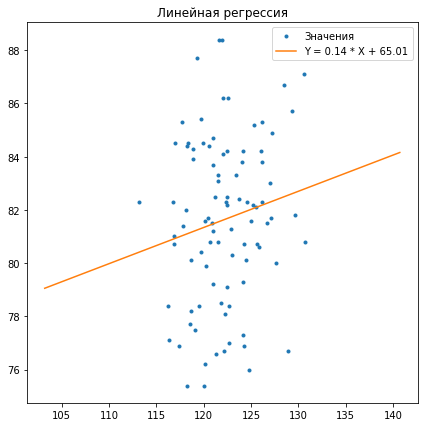

In [94]:
X_data = data['Z14,15,16_x'].to_numpy()
X_data = X_data[~np.isnan(X_data)]
Y_data = data['Z14,15,16_y'].to_numpy()
Y_data = Y_data[~np.isnan(Y_data)]

linear_reg(X_data, Y_data)